## Import libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import os
import matplotlib.pyplot as plt
torch.manual_seed(1)

In [2]:
print(torch.cuda.is_available())

True


If the above output **False** means you can't use cuda acceleration. Don't worry It'll still work fine.

## Define CNN

Network structure:

Conv2d -> Activation -> MaxPooling -> Conv2d -> Activation -> MaxPooling -> Flattening -> FullyConnected

Used function:
- Convolution: nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
- Activation: nn.ReLU()
- MaxPooling: nn.MaxPool2d(kernel_size)
- FullyConnected: nn.Linear(input_channels, output_channels)

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(1, 6, 5, padding=2),  # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(6, 16, 5),            # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.lin1 = nn.Sequential(
            nn.Linear(16*5*5, 120),   # fully connected layer, output 10 classes
            nn.ReLU()
        )
        self.lin2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU()
        )
        self.out = nn.Sequential(
            nn.Linear(84, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = self.lin1(x)
        x = self.lin2(x)
        output = self.out(x)
        return output, x    # return x for visualization

In [4]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lin1): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
  )
  (lin2): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
  )
  (out): Sequential(
    (0): Linear(in_features=84, out_features=10, bias=True)
    (1): ReLU()
  )
)


## Preparing Dataset

Check if MNIST is already downloaded

In [5]:
DOWNLOAD_FM = False
# Mnist digits dataset
if not(os.path.exists('./dataset/FashionMNIST/')) or not os.listdir('./dataset/FashionMNIST/'):
    # not mnist dir or mnist is empyt dir
    DOWNLOAD_FM = True
    
print(DOWNLOAD_FM)


False


Loading training data

In [6]:
# Data preprocessing: normalize image data so that grayscale data is between -1 and +1
tf = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.5,), (0.5,))])

train_data = torchvision.datasets.FashionMNIST(
    root='./dataset/',
    train=True,
    transform=tf,
    download=DOWNLOAD_FM,
)
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)

pick 2000 samples to speed up testing

In [7]:
test_data = torchvision.datasets.FashionMNIST(
    root='./dataset/',
    train=False,
    transform=tf
)
test_loader = Data.DataLoader(test_data, batch_size=64, shuffle=True)

plot one example

torch.Size([60000, 28, 28])
torch.Size([60000])


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


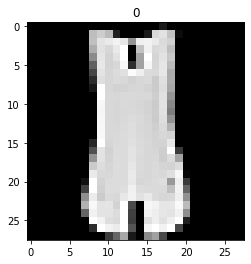

In [8]:
PIC_IDX = 4 # change this to see different picture
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[PIC_IDX].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[PIC_IDX])
plt.show()

## Training
Now we are ready to train

In [9]:
EPOCH = 5               # train the training data n times, to save time, we just train 1 epoch
LR = 0.01              # learning rate

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

In [14]:
train_losses, test_losses = [], []
# criterion = nn.NLLLoss()

for epoch in range(EPOCH):
    running_loss = 0
    for step, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        log_ps, hidden = cnn(images)
        loss = loss_func(log_ps, labels)
        loss.backward()
        optimizer.step()
#         running_loss += loss.item()
    
        if step%100 == 0:
            test_loss = 0
            accuracy = 0
            with torch.no_grad():
                cnn.eval()
                for images, labels in test_loader:
    
                    log_ps, hidden = cnn(images)
                    test_loss += loss_func(log_ps, labels)
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

                print("epoch: {}/{}| ".format(epoch+1, EPOCH),
                      "step: {}/{}|".format(step,len(train_loader)),
                      "train loss: {:.3f}| ".format(loss.data.numpy()),
                      "Validation loss: {:.3f}| ".format(test_loss/len(test_loader)),
                      "accuracy: {:.3f}".format(accuracy/len(test_loader)))
                cnn.train()
            
#                       "training loss: {:.3f}| ".format(running_loss/len(train_loader)),

epoch: 0/5|  step: 0/938| train loss: 0.362|  Validation loss: 0.387|  accuracy: 0.870
epoch: 0/5|  step: 100/938| train loss: 0.318|  Validation loss: 0.381|  accuracy: 0.868
epoch: 0/5|  step: 200/938| train loss: 0.276|  Validation loss: 0.392|  accuracy: 0.860
epoch: 0/5|  step: 300/938| train loss: 0.355|  Validation loss: 0.377|  accuracy: 0.871
epoch: 0/5|  step: 400/938| train loss: 0.570|  Validation loss: 0.370|  accuracy: 0.874
epoch: 0/5|  step: 500/938| train loss: 0.446|  Validation loss: 0.400|  accuracy: 0.864
epoch: 0/5|  step: 600/938| train loss: 0.326|  Validation loss: 0.363|  accuracy: 0.875
epoch: 0/5|  step: 700/938| train loss: 0.323|  Validation loss: 0.370|  accuracy: 0.868
epoch: 0/5|  step: 800/938| train loss: 0.362|  Validation loss: 0.393|  accuracy: 0.860
epoch: 0/5|  step: 900/938| train loss: 0.256|  Validation loss: 0.384|  accuracy: 0.869
epoch: 1/5|  step: 0/938| train loss: 0.200|  Validation loss: 0.406|  accuracy: 0.869
epoch: 1/5|  step: 100/93

print 10 predictions from test data

In [ ]:
test_output, _ = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')